In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

#Normalize pixel values
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/images/training",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/images/training",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/images/testing",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Mounted at /content/drive
Found 1914 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([

    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Flatten(),

    #Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [ ]:
model.save("pageflip_cnn_model1.keras")

In [ ]:
#First run
test_loss, test_acc = model.evaluate(test_data)
print("Test accuracy:", test_acc)

19/19 ━━━━━━━━━━━━━━━━━━━━ 337s 19s/step - accuracy: 0.8086 - loss: 0.7699
Test accuracy: 0.9179229736328125


In [ ]:
#Second run
test_loss, test_acc = model.evaluate(test_data)
print("Test accuracy:", test_acc)

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 447ms/step - accuracy: 0.8086 - loss: 0.7699
Test accuracy: 0.9179229736328125


In [ ]:
import numpy as np

predictions = model.predict(test_data)
pred_labels = (predictions > 0.5).astype(int)

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step


In [ ]:
y_true = test_data.classes

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_true, pred_labels)
print("Test Accuracy:", accuracy)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, pred_labels))

print("\nClassification Report:")
print(classification_report(y_true, pred_labels, target_names=['notflip', 'flip']))


Test Accuracy: 0.9179229480737019

Confusion Matrix:
[[242  48]
 [  1 306]]

Classification Report:
              precision    recall  f1-score   support

     notflip       1.00      0.83      0.91       290
        flip       0.86      1.00      0.93       307

    accuracy                           0.92       597
   macro avg       0.93      0.92      0.92       597
weighted avg       0.93      0.92      0.92       597



In [ ]:
print(train_data.class_indices)

{'flip': 0, 'notflip': 1}


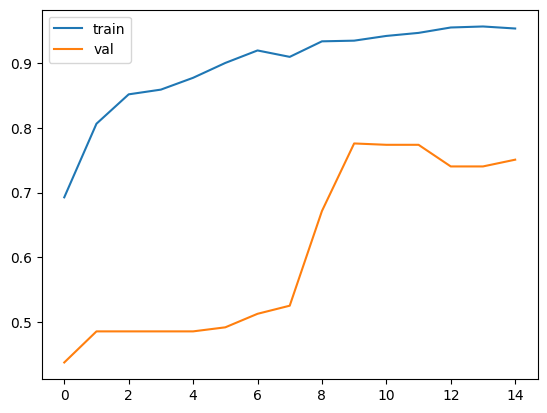

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()


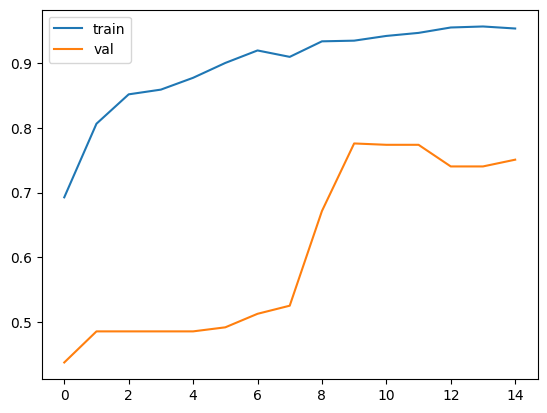

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

# Vision Transformer Implementation

In [ ]:
!pip install torch torchvision transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from transformers import AutoImageProcessor, AutoModelForImageClassification


MODEL_NAME = "WinKawaks/vit-tiny-patch16-224"
NUM_CLASSES = 2
BATCH_SIZE = 16
LR = 2e-5
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

#Initial transforms, pretty simple
'''train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])'''

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])


#This set of training transforms should improve generalisation on training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    #Geometric
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),

    #Photometric
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2
    ),

    #Blur/Noise
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.2),

    transforms.ToTensor(),

    #ViT normalization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


from torch.utils.data import random_split

#Load entire training dataset first
full_train_ds = datasets.ImageFolder(
    "/content/drive/MyDrive/images/training",
    transform=train_transform
)

train_size = int(0.8 * len(full_train_ds))
val_size = len(full_train_ds) - train_size

train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])
test_ds = datasets.ImageFolder("/content/drive/MyDrive/images/testing", transform=test_transform)


#Assign correct transforms after splitting
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = test_transform

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


'''train_ds = datasets.ImageFolder("/content/drive/MyDrive/images/training", transform=train_transform)
val_ds   = datasets.ImageFolder("/content/drive/MyDrive/images/testing", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)'''



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


'train_ds = datasets.ImageFolder("/content/drive/MyDrive/images/training", transform=train_transform)\nval_ds   = datasets.ImageFolder("/content/drive/MyDrive/images/testing", transform=test_transform)\n\ntrain_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)\nval_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)'

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True  #important for custom heads
)
model.to(DEVICE)


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=192, out_features=768, bias=True)
            (intermedi

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

def train_one_epoch():
    model.train()
    total_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    return total_loss / len(train_loader), acc

def validate():
    model.eval()
    correct = 0
    total_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).logits

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    acc = correct / len(val_loader.dataset)
    return total_loss / len(val_loader), acc

In [ ]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch()
    val_loss, val_acc = validate()

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}  |  Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}    |  Val Acc:   {val_acc:.4f}")

Epoch 1/10
  Train Loss: 0.1620  |  Train Acc: 0.9378
  Val Loss:   0.0264    |  Val Acc:   0.9916
Epoch 2/10
  Train Loss: 0.0202  |  Train Acc: 0.9942
  Val Loss:   0.0044    |  Val Acc:   1.0000
Epoch 3/10
  Train Loss: 0.0025  |  Train Acc: 0.9990
  Val Loss:   0.0020    |  Val Acc:   1.0000
Epoch 4/10
  Train Loss: 0.0006  |  Train Acc: 1.0000
  Val Loss:   0.0019    |  Val Acc:   1.0000
Epoch 5/10
  Train Loss: 0.0003  |  Train Acc: 1.0000
  Val Loss:   0.0012    |  Val Acc:   1.0000
Epoch 6/10
  Train Loss: 0.0002  |  Train Acc: 1.0000
  Val Loss:   0.0010    |  Val Acc:   1.0000
Epoch 7/10
  Train Loss: 0.0002  |  Train Acc: 1.0000
  Val Loss:   0.0009    |  Val Acc:   1.0000
Epoch 8/10
  Train Loss: 0.0001  |  Train Acc: 1.0000
  Val Loss:   0.0007    |  Val Acc:   1.0000
Epoch 9/10
  Train Loss: 0.0001  |  Train Acc: 1.0000
  Val Loss:   0.0007    |  Val Acc:   1.0000
Epoch 10/10
  Train Loss: 0.0001  |  Train Acc: 1.0000
  Val Loss:   0.0006    |  Val Acc:   1.0000


In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0178
Test Accuracy: 0.9966


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            outputs = model(images)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    #Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    #Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

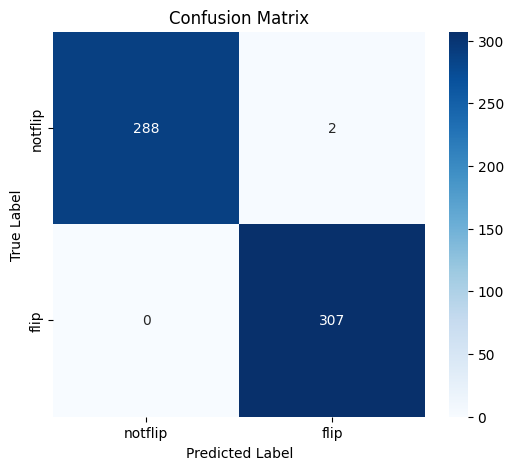


Classification Report:
              precision    recall  f1-score   support

     notflip       1.00      0.99      1.00       290
        flip       0.99      1.00      1.00       307

    accuracy                           1.00       597
   macro avg       1.00      1.00      1.00       597
weighted avg       1.00      1.00      1.00       597



In [ ]:
class_names = ["notflip", "flip"]

plot_confusion_matrix(
    model,
    test_loader,
    DEVICE,
    class_names
)
